In [1]:
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np

In [2]:
# Image path
file_path = 'data/img04g.tif'

im = Image.open(file_path)
imarray = np.array(im)

imarray = imarray[:200, :200]
print("The size of the input figure is: ", imarray.shape)

The size of the input figure is:  (200, 200)


In [3]:
# Parameters

# image size
imgHeight = imarray.shape[0]
imgWidth = imarray.shape[1]

# display size
sHeight = imgHeight/40
sWidth = imgWidth/40

# gaussian white noise
nMean = 0
nStd = 8
nVariance = nStd ** 2

# gaussian noncausal prediction filter
g_filter = np.asarray([
    [1/12, 1/6, 1/12],
    [1/6, 0, 1/6],
    [1/12, 1/6, 1/12],
])
window_size = 3

# other parameters
rho = 100
alpha_param = 0.5

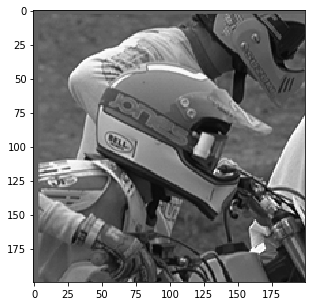

In [4]:
plt.figure(figsize = (sHeight, sWidth))
plt.imshow(imarray, cmap=plt.get_cmap('gray'))

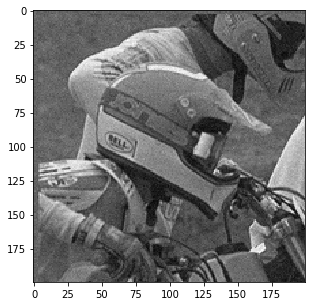

In [5]:
# Add Gaussian Noise.
noisy_img = imarray + (np.random.randn(imarray.shape[0], imarray.shape[1]) * nStd + nMean)
plt.figure(figsize = (sHeight, sWidth))
plt.imshow(noisy_img, cmap=plt.get_cmap('gray'))

In [6]:
def calculate_prediction_variance(x, g_filter, p=2):
  """
  x: 2d image
  g_filter: 3*3 filter
  """

  sigmaP_sum = []
  for i in range(1, x.shape[0] - 1):
    for j in range(1, x.shape[1] - 1):

      x_center = x[i, j]
      for pi in range(3):
        for pj in range(3):
          x_neighbor = x[i + pi - 1, i + pj - 1]
          sigmaP_sum.append(g_filter[pi, pj] * np.abs(x_center - x_neighbor) ** p)

  return np.mean(sigmaP_sum)

In [7]:
variance_x = calculate_prediction_variance(noisy_img, g_filter)

In [8]:
def calculate_bar(Z):
  """
  Z: height * width * 3 * 3 matrix
  """

  height = Z.shape[0]
  width = Z.shape[1]
  z_consensus = np.zeros((height, width))
  for vi in range(height):
    for vj in range(width):
      v_sum = 0
      for pi in range(3):
        for pj in range(3):
          v_sum += Z[
            (vi + pi - 1 + height) % height, (vj + pj - 1 + width) % width,
            2 - pi, 2 - pj
          ]
      z_consensus[vi, vj] = v_sum / 9

  return z_consensus

In [9]:
def construct_consensus_x(z_consensus, vi, vj):
  """
  z_consensus: height * width consensus matrix
  vi: index along the axis of height
  vj: index along the axis of width
  """

  x = np.zeros((window_size, window_size))

  for pi in range(window_size):
    for pj in range(window_size):
      x[pi, pj] = z_consensus[
        (vi + pi - 1 + imgHeight) % imgHeight,
        (vj + pj - 1 + imgWidth) % imgWidth
      ]

  return x

In [10]:
def update_consensus_z(z_consensus, vi, vj, updated_mat):
  """
  z_consensus: height * width consensus matrix
  vi: index along the axis of height
  vj: index along the axis of width
  updated_mat: the matrix to be updated, window_size * windowsize
  """
  for pi in range(window_size):
    for pj in range(window_size):
      z_consensus[
        (vi + pi - 1 + imgHeight) % imgHeight,
        (vj + pj - 1 + imgWidth) % imgWidth
      ] = updated_mat[pi, pj]

  return z_consensus

In [11]:
# Calculate some coefficients

alpha = np.sum(g_filter ** 2 / (g_filter + variance_x / rho))
alpha = alpha / variance_x

gamma = 1 / variance_x + 1 / nVariance + 1 / rho

beta = g_filter / (g_filter * rho + variance_x)
beta = np.reshape(beta, (beta.shape[0] * beta.shape[1], 1))  # row first

phi = variance_x / (g_filter * rho + variance_x)
phi = np.reshape(phi, (phi.shape[0] * phi.shape[1], 1))  # row first

In [12]:
print(" ****** PARAMETERS ****** ")
print("alpha = {}".format(alpha))
print("gamma = {}".format(gamma))
print("beta = {}".format(beta))
print("phi = {}".format(phi))

 ****** PARAMETERS ****** 
alpha = 5.6209686569503103e-05
gamma = 0.02766727642751564
beta = [[0.00016734]
 [0.00032917]
 [0.00016734]
 [0.00032917]
 [0.        ]
 [0.00032917]
 [0.00016734]
 [0.00032917]
 [0.00016734]]
phi = [[0.98326583]
 [0.9670825 ]
 [0.98326583]
 [0.9670825 ]
 [1.        ]
 [0.9670825 ]
 [0.98326583]
 [0.9670825 ]
 [0.98326583]]


In [13]:
# initialize z

z = np.random.randint(0, 255, (imgHeight, imgWidth, g_filter.shape[0], g_filter.shape[1]))
# z = np.repeat(noisy_img[:, :, np.newaxis], 3, axis=-1)
# z = np.repeat(z[:, :, :, np.newaxis], 3, axis=-1)
x_hat = np.zeros((imgHeight, imgWidth, g_filter.shape[0], g_filter.shape[1]))

z_entries_num = imgHeight * imgWidth * g_filter.shape[0] * g_filter.shape[1]


# initial consensus
z_consensus = calculate_bar(z)

Epoch 0, the difference between z (square sum): 43594
Epoch 0, the difference between z (averaged value): 0.0005799771174711322


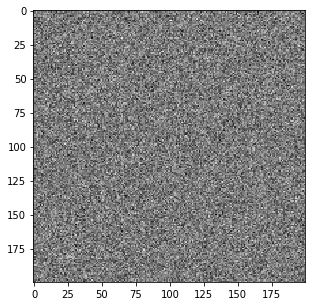

Epoch 40000, the difference between z (square sum): 52482
Epoch 40000, the difference between z (averaged value): 0.0006363597282227275
Epoch 80000, the difference between z (square sum): 615
Epoch 80000, the difference between z (averaged value): 6.88866487090958e-05
Epoch 120000, the difference between z (square sum): 251
Epoch 120000, the difference between z (averaged value): 4.400827643820794e-05
Epoch 160000, the difference between z (square sum): 247
Epoch 160000, the difference between z (averaged value): 4.365620457083809e-05
Epoch 200000, the difference between z (square sum): 326
Epoch 200000, the difference between z (averaged value): 5.01540835701883e-05
Epoch 240000, the difference between z (square sum): 5
Epoch 240000, the difference between z (averaged value): 6.211299937499416e-06
Epoch 280000, the difference between z (square sum): 336
Epoch 280000, the difference between z (averaged value): 5.0917507721731554e-05
Epoch 320000, the difference between z (square sum): 

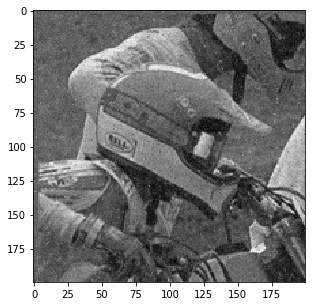

Epoch 440000, the difference between z (square sum): 9
Epoch 440000, the difference between z (averaged value): 8.333333333333334e-06
Epoch 480000, the difference between z (square sum): 7
Epoch 480000, the difference between z (averaged value): 7.3493091974016405e-06
Epoch 520000, the difference between z (square sum): 4
Epoch 520000, the difference between z (averaged value): 5.555555555555556e-06
Epoch 560000, the difference between z (square sum): 167
Epoch 560000, the difference between z (averaged value): 3.58967999536669e-05
Epoch 600000, the difference between z (square sum): 0
Epoch 600000, the difference between z (averaged value): 0.0
Epoch 640000, the difference between z (square sum): 23
Epoch 640000, the difference between z (averaged value): 1.332175423142422e-05
Epoch 680000, the difference between z (square sum): 2
Epoch 680000, the difference between z (averaged value): 3.928371006591931e-06
Epoch 720000, the difference between z (square sum): 3
Epoch 720000, the diff

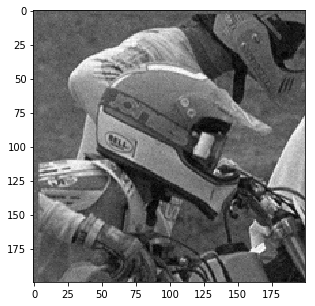

Epoch 840000, the difference between z (square sum): 1
Epoch 840000, the difference between z (averaged value): 2.777777777777778e-06
Epoch 880000, the difference between z (square sum): 2
Epoch 880000, the difference between z (averaged value): 3.928371006591931e-06
Epoch 920000, the difference between z (square sum): 1
Epoch 920000, the difference between z (averaged value): 2.777777777777778e-06
Epoch 960000, the difference between z (square sum): 2
Epoch 960000, the difference between z (averaged value): 3.928371006591931e-06
Epoch 1000000, the difference between z (square sum): 0
Epoch 1000000, the difference between z (averaged value): 0.0
Epoch 1040000, the difference between z (square sum): 0
Epoch 1040000, the difference between z (averaged value): 0.0
Epoch 1080000, the difference between z (square sum): 0
Epoch 1080000, the difference between z (averaged value): 0.0
Epoch 1120000, the difference between z (square sum): 0
Epoch 1120000, the difference between z (averaged valu

In [14]:
epoch_num = imgWidth * imgHeight * 30
for epoch_i in range(epoch_num):
  pi = np.random.randint(imgHeight)
  pj = np.random.randint(imgWidth)

  z_memory = z[pi, pj].copy()
  # construct the consensus result
  x_hat = construct_consensus_x(z_consensus, pi, pj)
  x_hat[x_hat > 255] = 255
  x_hat[x_hat < 0] = 0

  prox_point = 2 * x_hat - z_memory
  prox_point_vec = np.reshape(prox_point, (prox_point.shape[0] * prox_point.shape[1], 1))
  x_i = 1 / (gamma - alpha) * (1 / nVariance * noisy_img[pi, pj] +
                               1 / rho * prox_point_vec[4] + np.matmul(beta.T, prox_point_vec))
  x_j_vec = rho * x_i * beta + phi * prox_point_vec
  x_vec = np.reshape(x_j_vec, (prox_point.shape[0], prox_point.shape[1]))
  x_vec[1, 1] = x_i

  # update z
  z_update = z_memory + 2 * alpha_param * (x_vec - x_hat)
  z[pi, pj] = z_update

  # update z_consensus

  consensus_updated = x_hat + 1 / 9 * (z[pi, pj] - z_memory)
  z_consensus = update_consensus_z(z_consensus, pi, pj, consensus_updated)

  if not epoch_i % (imgWidth * imgHeight):
    print("Epoch {}, the difference between z (square sum): {}".format(
      epoch_i,
      (np.sum((z[pi, pj] - z_memory) ** 2))
    )
    )
    print("Epoch {}, the difference between z (averaged value): {}".format(
      epoch_i,
      (np.sum((z[pi, pj] - z_memory) ** 2)) ** 0.5 / z_entries_num
    )
    )

  if not epoch_i % (10 * imgWidth * imgHeight):
    plt.figure(figsize=(sHeight, sWidth))
    plt.imshow(z_consensus, cmap=plt.get_cmap('gray'))
    plt.show()

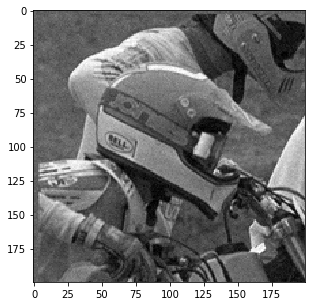

In [15]:
plt.figure(figsize = (sHeight, sWidth))
plt.imshow(z_consensus, cmap=plt.get_cmap('gray'))
plt.show()